# Deploy SD1.5/2.1/XL to Inferentia2 + SageMaker + HF Optimum Neuron

**SageMaker Studio Kernel**: Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)  
**Instance**: ml.t3.medium


## 1) Update SageMaker SDK

In [ ]:
%pip install -U sagemaker
%pip install matplotlib

## 2) Initialize session

In [ ]:
import os
import boto3
import sagemaker

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()
region = sess.boto_region_name

os.makedirs("src", exist_ok=True)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bucket}")
print(f"sagemaker session region: {region}")

## 3) Create artifacts to compile & run the model

### 3.1) Dependencies file

In [ ]:
%%writefile src/requirements.txt
--extra-index-url https://pip.repos.neuron.amazonaws.com
evaluate==0.4.1
diffusers==0.26.3
accelerate==0.23.0
scikit-learn==1.4.0
transformers==4.36.2
optimum-neuron==0.0.20
neuronx-distributed==0.6.0
transformers-neuronx==0.9.474

### 3.2) Python script for compiling and deploying the model

This script will download model weights from HF, compile each module to inf2 and save the compiled artifacts to S3

The envvar **NEURON_RT_NUM_CORES** controls how many NeuronCores are allocated per process. SageMaker can launch multiple processess in just one Endpoint. It means you can increase throughput of your endpoint by deploying your model to a larger instance (inf2.24xlarge or inf2.48xlarge). On an inf2.24xlarge, for instance, SageMaker can deploy 6 copies of the same model in parallel to serve 6 simultaneous clients. This is what we'll do in the next steps.

In [ ]:
%%writefile src/compile.py
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import os
os.environ['NEURON_RT_NUM_CORES'] = '2'
import io
import json
import time
import base64
import shutil
import argparse
import optimum.neuron as on

from PIL import Image
from filelock import Timeout, FileLock

lock_path='/tmp/new_packages.lock'
lock = FileLock(lock_path)

def model_fn(model_dir, context=None):
    print("Waiting for the lock acquire...")    
    lock.acquire()
    print("Loading model...")
    t=time.time()
    inpaint = "Inpaint" if os.environ.get('INPAINT', 'false').lower() in ['true', '1'] else ""
    xl = "XL" if os.environ.get('XL', 'false').lower() in ['true', '1'] else ""
    pipe = eval(f'on.NeuronStableDiffusion{xl}{inpaint}Pipeline')
    model = pipe.from_pretrained(model_dir,  device_ids=[0, 1])
    print(f"Model loaded. Elapsed: {time.time()-t}s")
    lock.release()
    return model
    
def input_fn(request_body, request_content_type, context=None):
    if request_content_type == 'application/json':
        req = json.loads(request_body)
        if os.environ.get('INPAINT', 'false').lower() in ['true', '1']:
            print('Convert images from Base64 and decompress them')
            req['image'] = Image.open(io.BytesIO(base64.b64decode(req['image'])))
            req['mask_image'] = Image.open(io.BytesIO(base64.b64decode(req['mask_image'])))
        return req
    else:
        raise Exception(f"Unsupported mime type: {request_content_type}. Supported: application/json")

def predict_fn(input_req, model, context=None):    
    return model(**input_req).images[0]

def output_fn(image, accept, context=None):
    if accept!='image/jpeg':
        raise Exception(f'Invalid data type. Expected image/jpeg, got {accept}')

    buffer = io.BytesIO()
    image.save(buffer, 'jpeg', icc_profile=image.info.get('icc_profile'))
    buffer.seek(0)
    return buffer.read()

if __name__=='__main__':
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.    
    parser.add_argument("--model_id", type=str, default="stabilityai/stable-diffusion-2-1-base")
    parser.add_argument("--batch_size", type=int, default=1)
    parser.add_argument("--height", type=int, default=512)
    parser.add_argument("--width", type=int, default=512)
    parser.add_argument("--auto_cast", type=str, default="matmul")
    parser.add_argument("--auto_cast_type", type=str, default="bf16")

    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--inpaint", type=str, choices=['True', 'False'], default=os.environ.get("INPAINT", 'false').lower()=='true')
    parser.add_argument("--xl", type=str, choices=['True', 'False'], default=os.environ.get("XL", 'false').lower()=='true')
    
    args, _ = parser.parse_known_args()

    model_id = args.model_id
    compiler_args = {"auto_cast": args.auto_cast, "auto_cast_type": args.auto_cast_type}
    input_shapes = {"batch_size": args.batch_size, "height": args.height, "width": args.width}

    print("Compiling model...")    
    t=time.time()
    
    inpaint = "Inpaint" if args.inpaint=="True" else ""
    xl = "XL" if args.xl=="True" else ""
    pipe_class = f'on.NeuronStableDiffusion{xl}{inpaint}Pipeline'
    print(f"Pipe class: {pipe_class}")
    pipe = eval(pipe_class)
    
    stable_diffusion = pipe.from_pretrained(model_id, export=True, **compiler_args, **input_shapes)
    print(f"Done. Elapsed time: {(time.time()-t) * 1000}s")
    print("Saving model...")
    t=time.time()
    stable_diffusion.save_pretrained(args.model_dir)
    print(f"Done. Elapsed time: {(time.time()-t) * 1000}s")

    code_path = os.path.join(args.model_dir, "code")
    os.makedirs(code_path, exist_ok=True)
    shutil.copy("compile.py", os.path.join(code_path, "inference.py"))
    shutil.copy("requirements.txt", os.path.join(code_path, "requirements.txt"))
    print(f"Job done!")
    os._exit(0)

## 4) SageMaker (training) Job that will download and compile the model

**ATTENTION**: You need to run this step only once. Then, you can deploy the compiled model as many times as you need.

In [ ]:
inpaint = False

# SD XL
#model_id,width,height,xl="stabilityai/stable-diffusion-xl-base-1.0",1024,1024,True
# SD 2.1
#model_id,width,height,xl="stabilityai/stable-diffusion-2-1-base",512,512,False
# SD 1.5 fine-tuned for realistic person & background generation
model_id,width,height,xl="SG161222/Realistic_Vision_V6.0_B1_noVAE",896,896,False

In [ ]:
import json
import logging
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="src",
    role=role,
    sagemaker_session=sess,    
    instance_count=1,
    instance_type='ml.trn1.32xlarge', # a big instance is required for compilation
    output_path=f"s3://{bucket}/output",
    disable_profiler=True,
    disable_output_compression=True,

    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training-neuronx:1.13.1-neuronx-py310-sdk2.17.0-ubuntu20.04",
    
    volume_size = 128,
    hyperparameters={
        "model_id": model_id,
        "width": width,
        "height": height,
        "xl": xl,
        "inpaint": inpaint
    }
)
estimator.framework_version = '1.13.1' # workround when using image_uri
print(model_id,width,height,xl,inpaint)

In [ ]:
# trn1.32xlarge
estimator.fit()

In [ ]:
print("""
If you decide to run this notebook again, you don't need to re-compile the model.
Just keep the following path and use it to deploy the model next time.
""")
model_data = estimator.model_data
print(estimator.model_data)

## 5) Deploy the compiled model to a SageMaker endpoint on inf2
SageMaker can launch multiple workers, depending on the size of the Inf2 instance. A worker is a standalone Python process that manages one copy of the model. SageMaker puts a load balancer on top of all these processes and distributes the load automatically for your clients. It means that you can increase throughput by launching multiple workers, which serve different clients in parallel.

For instance. If you deploy the model to a **ml.inf2.48xlarge**, SageMaker can launch 12 workers with 12 copies of the model. This instance has 24 cores and each copy of the model utilizes 2 cores. Then, you can have 12 simultaneous clients invoking the endpoint and being served at the same time.

In [ ]:
import logging
from sagemaker.utils import name_from_base
from sagemaker.pytorch.model import PyTorchModel

# depending on the inf2 instance you deploy the model you'll have more or less accelerators
# we'll ask SageMaker to launch 1 worker per core

instance_type_idx=0
instance_types=['ml.inf2.8xlarge', 'ml.inf2.24xlarge','ml.inf2.48xlarge']
num_cores=[2,12,24]
num_workers=num_cores[instance_type_idx]//2
suffix = ""
suffix += "-xl" if xl else "" 
suffix += "-inpaint" if inpaint else ""

print(f"Instance type: {instance_types[instance_type_idx]}. Num SM workers: {num_workers}")
pytorch_model = PyTorchModel(
    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-inference-neuronx:1.13.1-neuronx-py310-sdk2.17.0-ubuntu20.04",
    model_data=model_data,
    role=role,    
    name=name_from_base(f'sd{suffix}'),
    sagemaker_session=sess,
    container_log_level=logging.DEBUG,
    model_server_workers=num_workers,
    framework_version="1.13.1",
    env = {
        'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600',
        'INPAINT': "true" if inpaint else "false",
        'XL': "true" if xl else "false"
    },
    # for production it is important to define vpc_config and use a vpc_endpoint
    #vpc_config={
    #    'Subnets': ['<SUBNET1>', '<SUBNET2>'],
    #    'SecurityGroupIds': ['<SECURITYGROUP1>', '<DEFAULTSECURITYGROUP>']
    #}
)
pytorch_model._is_compiled_model = True
print(pytorch_model.env)

In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_types[instance_type_idx],
    model_data_download_timeout=600, # it takes some time to download all the artifacts and load the model
    container_startup_health_check_timeout=600
)

## 6) Run a simple test to check the endpoint

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = JSONSerializer()
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

6 images generated in 33.61s.


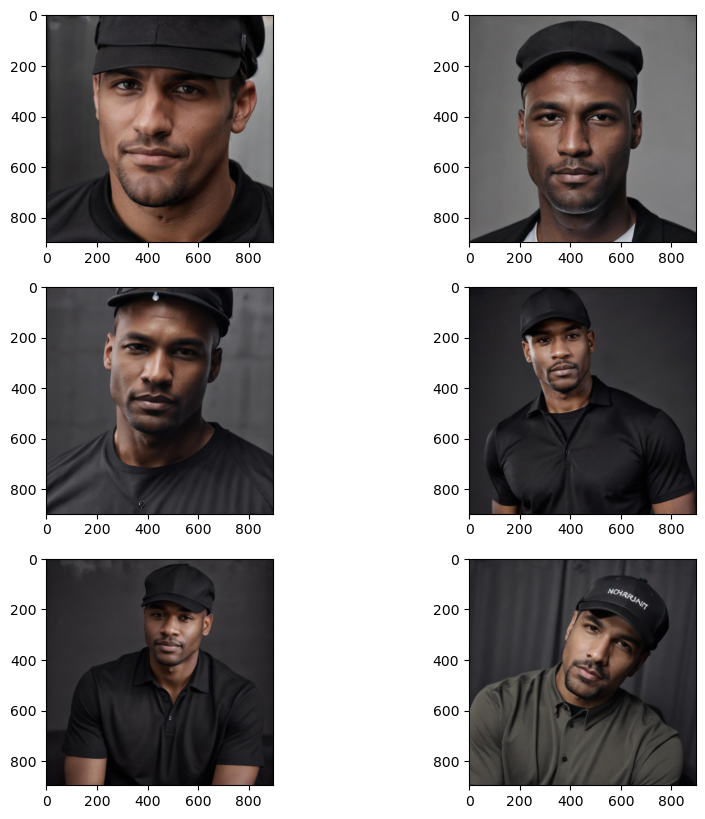

In [78]:
%matplotlib inline

import io
import time
import base64
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool

# adjust this number according to the instance size and number of workers
num_clients = num_workers
#prompt = "high quality, portrait of 30 y.o woman, smiling, cinematic shot, desert with dunes and oasis"
prompt="high quality, face portrait photo of 30 y.o black man, wearing NY cap and black shirt, serious face, detailed face, skin pores, cinematic shot, empty background"
negative_prompt="(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation"
input_req={
    "prompt": prompt,
    "negative_prompt": negative_prompt,
    # more info about these 2 params here: https://huggingface.co/blog/stable_diffusion
    "num_inference_steps": 150, # >100 steps for a good quality image
    "guidance_scale": 7.5
}
if inpaint:
    input_req['image'] = base64.b64encode(open('your_image_here.jpg', 'rb').read()).decode('utf-8')
    input_req['mask_image'] = base64.b64encode(open('mask_of_your_image_here.png', 'rb').read()).decode('utf-8')

input_reqs=[input_req] * num_clients

def predict(req):    
    data = predictor.predict(req)
    return data

with ThreadPool(num_clients) as p:
    t=time.time()
    data = p.map(predict, input_reqs)
    print(f"{len(data)} images generated in {(time.time()-t):0.2f}s.")

fig = plt.figure(figsize=(10, 10))
columns = 1 if num_workers%2 == 1 else 2
rows = num_workers // columns
j=0
for i in range(1, columns*rows +1):    
    fig.add_subplot(rows, columns, i)
    img = Image.open(io.BytesIO(data[j]))        
    plt.imshow(img)    
    j += 1
plt.show()

## 7) Cleanup
Delete the endpoint to stop paying for the provisioned resources

In [33]:
predictor.delete_model()
predictor.delete_endpoint()